<a href="https://colab.research.google.com/github/ReynaldiJ/portfolio/blob/main/AOL_Text_mining.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# AOL Text Mining
# 2540131374 - Alexander Ryan Wijaya
# 2502001763 - Darren Engelbert
# 2502041956 - Nicholas Javier
# 2540124356 - Reynaldi Joely

Link Collab: https://colab.research.google.com/drive/12MkgzTcwsazRGZ6MJxMhbtXchaxCaNoN?usp=sharing

Link Video:https://www.youtube.com/watch?v=0uSKvSaileQ


In [ ]:
# Importing all necessary libraries
import pandas as pd
import tensorflow as tf
from transformers import BertTokenizer, TFBertForSequenceClassification
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score
import torch
import torch.nn as nn
import torch.optim as optim
!pip install nltk
import re
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.corpus import stopwords
import nltk
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Exploratory Data Analysis

The dataset used are from kaggle (https://www.kaggle.com/datasets/nelgiriyewithana/emotions/data )

In [ ]:
import zipfile
# Extracting from zipped file
zip_file_path = '/content/archive (16).zip'  # Replace with the path to your zip file
extract_folder = 'extracted_data'
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_folder)

In [ ]:
df = pd.read_csv('/content/extracted_data/text.csv', encoding='latin-1')

In [ ]:
df.head()

,Unnamed: 0,text,label
0,0,i just feel really helpless and heavy hearted,4
1,1,ive enjoyed being able to slouch about relax a...,0
2,2,i gave up my internship with the dmrg and am f...,4
3,3,i dont know i feel so lost,0
4,4,i am a kindergarten teacher and i am thoroughl...,4


From the table head above we can see that this data contains text as the input, and ['joy', 'anger', 'fear', 'surprise', 'love', and 'sadness'] as the label

In [ ]:
df.isnull().sum()

Unnamed: 0    0
text          0
label         0
dtype: int64

In [ ]:
df = df.drop('Unnamed: 0', axis=1)

In [ ]:
df

,text,label
0,i just feel really helpless and heavy hearted,4
1,ive enjoyed being able to slouch about relax a...,0
2,i gave up my internship with the dmrg and am f...,4
3,i dont know i feel so lost,0
4,i am a kindergarten teacher and i am thoroughl...,4
...,...,...
416804,i feel like telling these horny devils to find...,2
416805,i began to realize that when i was feeling agi...,3
416806,i feel very curious be why previous early dawn...,5
416807,i feel that becuase of the tyranical nature of...,3


<ipython-input-11-bb6569341830>:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=count.index, y=count.values, ax=axs[1], palette="viridis")


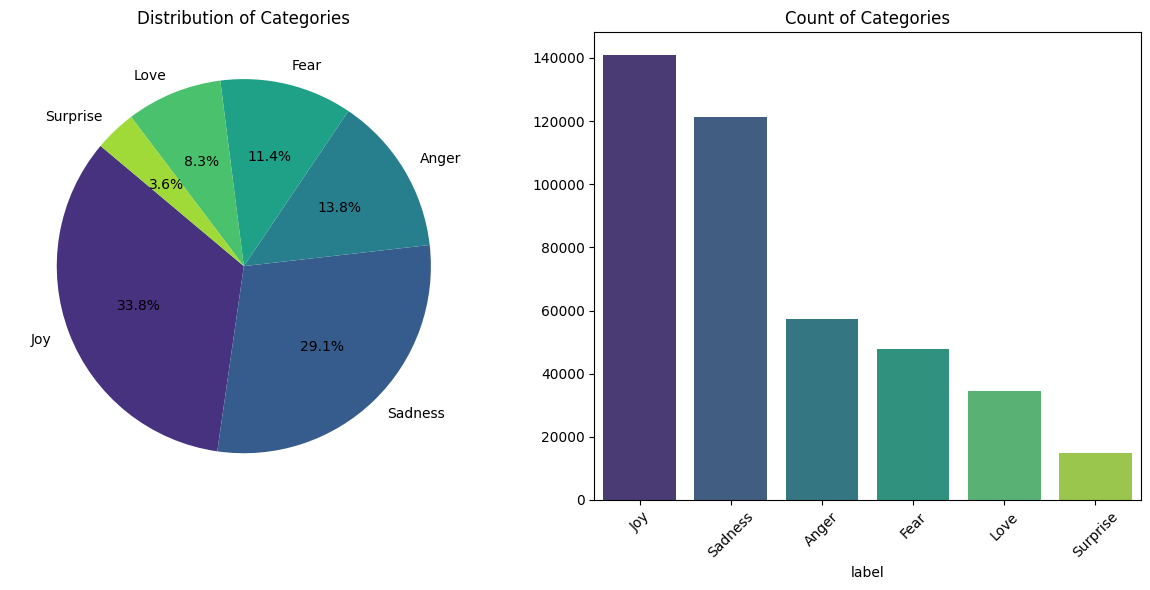

In [ ]:
count = df['label'].value_counts()

# Memetakan label numerik ke nama kelas
label_names = {
    0: 'Sadness',
    1: 'Joy',
    2: 'Love',
    3: 'Anger',
    4: 'Fear',
    5: 'Surprise'
}

count.index = count.index.map(label_names)

# Membuat figure dengan dua subplot
fig, axs = plt.subplots(1, 2, figsize=(12, 6), facecolor='white')

# Mengatur palette
palette = sns.color_palette("viridis")
sns.set_palette(palette)

# Plot pie chart di subplot pertama
axs[0].pie(count, labels=count.index, autopct='%1.1f%%', startangle=140)
axs[0].set_title('Distribution of Categories')

# Plot bar chart di subplot kedua
sns.barplot(x=count.index, y=count.values, ax=axs[1], palette="viridis")
axs[1].set_title('Count of Categories')

# Memutar label x untuk keterbacaan yang lebih baik
plt.setp(axs[1].xaxis.get_majorticklabels(), rotation=45)

# Menyesuaikan layout
plt.tight_layout()

# Menampilkan plot
plt.show()

<Axes: >

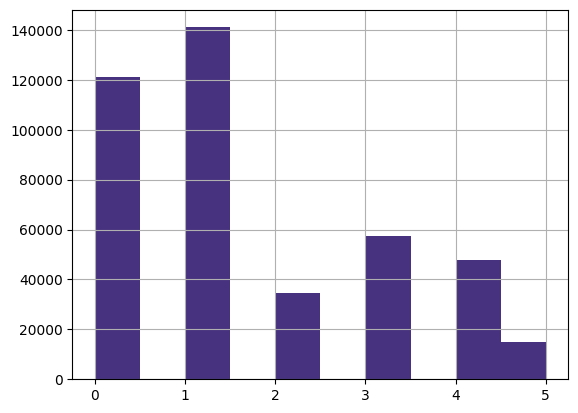

In [ ]:
df['label'].hist()

In [ ]:
import pandas as pd
from sklearn.utils import resample
class_size = 7000

class_counts = df['label'].value_counts()

downsampled_dfs = []

for label in class_counts.index:
    class_df = df[df['label'] == label]
    if class_counts[label] > class_size:
        downsampled_class_df = resample(class_df,
                                        replace=False,
                                        n_samples=class_size,
                                        random_state=42)
    else:
        downsampled_class_df = class_df
    downsampled_dfs.append(downsampled_class_df)

balanced_df = pd.concat(downsampled_dfs)

balanced_df = balanced_df.sample(frac=1, random_state=42)


In [ ]:
print(balanced_df['label'].value_counts())

label
1    7000
5    7000
4    7000
2    7000
0    7000
3    7000
Name: count, dtype: int64


# Data Preprocessing

In [ ]:
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('stopwords')

stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def preprocess_text(text):

    text = text.lower()

    text = re.sub(r'[^\w\s]', '', text)

    text = re.sub(r'\d+', '', text)

    text = ' '.join([word for word in text.split() if word not in ENGLISH_STOP_WORDS])

    return text

balanced_df['cleaned_text'] = balanced_df['text'].apply(preprocess_text)

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
balanced_df[['text', 'cleaned_text']]

,text,cleaned_text
104718,i listen to utada whenever i feel bouncy or i ...,listen utada feel bouncy need just groove
79359,i left you yesterday i was feeling overwhelmed...,left yesterday feeling overwhelmed motivated l...
104789,i feel my restless heart breathe settled firml...,feel restless heart breathe settled firmly fin...
413013,i am feeling very generous today,feeling generous today
369475,i always wonder if i should feel a little weir...,wonder feel little weird reading comes childre...
...,...,...
61002,i feel like this is one of those super handy d...,feel like super handy dishes feels fancy thank...
144726,i am feeling somewhat disheartened today,feeling somewhat disheartened today
104039,i went all the way back to the beginning and r...,went way beginning read wrote feeling music mo...
256920,i can still be a functional parent but more i ...,functional parent actually enjoy parenting thi...


# Splitting Data

The code below are used to split data into the required form [['train', 'test','split'], [70%, 15%, 15%]]. It is done like how it generally should be.

In [ ]:

train_df, test_val_df = train_test_split(balanced_df, test_size=0.3, random_state=42)
test_df, val_df = train_test_split(test_val_df, test_size=0.5, random_state=42)

# Vectorization


The provided code utilizes the 'bert-base-uncased' BERT model for fine-tuning on a downstream text classification task. It employs the Hugging Face Transformers library to tokenize the training, validation, and testing datasets, incorporating settings like truncation and padding. Labels are numerically encoded using pd.factorize. TensorFlow datasets are then created, with the training dataset shuffled and organized into batches. The code ensures consistency in input format for BERT, facilitating efficient training on a labeled dataset for subsequent downstream tasks such as sentiment analysis or classification.

In [ ]:

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
max_length = 128

train_encodings = tokenizer(train_df['cleaned_text'].tolist(), truncation=True, padding=True, max_length=max_length, return_tensors='tf')
val_encodings = tokenizer(val_df['cleaned_text'].tolist(), truncation=True, padding=True, max_length=max_length, return_tensors='tf')
test_encodings = tokenizer(test_df['cleaned_text'].tolist(), truncation=True, padding=True, max_length=max_length, return_tensors='tf')

train_labels = pd.factorize(train_df['label'])[0]
val_labels = pd.factorize(val_df['label'])[0]
test_labels = pd.factorize(test_df['label'])[0]

train_dataset = tf.data.Dataset.from_tensor_slices((
    dict(train_encodings),
    train_labels
)).shuffle(10000).batch(32)

val_dataset = tf.data.Dataset.from_tensor_slices((
    dict(val_encodings),
    val_labels
)).batch(32)

test_dataset = tf.data.Dataset.from_tensor_slices((
    dict(test_encodings),
    test_labels
)).batch(32)

In [ ]:
for input_data, label in train_dataset.take(5):
    print("Input data:", input_data)
    print("Label:", label)

Input data: {'input_ids': <tf.Tensor: shape=(32, 80), dtype=int32, numpy=
array([[ 101, 2074, 9535, ...,    0,    0,    0],
       [ 101, 2701, 3526, ...,    0,    0,    0],
       [ 101, 2113, 3658, ...,    0,    0,    0],
       ...,
       [ 101, 2428, 4339, ...,    0,    0,    0],
       [ 101, 2491, 6183, ...,    0,    0,    0],
       [ 101, 2113, 3110, ...,    0,    0,    0]], dtype=int32)>, 'token_type_ids': <tf.Tensor: shape=(32, 80), dtype=int32, numpy=
array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32)>, 'attention_mask': <tf.Tensor: shape=(32, 80), dtype=int32, numpy=
array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]], dtype=int32)>}
Label: tf.Tensor([1 5 4 1 

In [ ]:
print("Original Text:", train_df['text'].iloc[0])
print("Token IDs:", train_encodings['input_ids'][0])
print("Attention Mask:", train_encodings['attention_mask'][0])

Original Text: i feel like i m very regretful and so sorry for all of my fren and family there
Token IDs: tf.Tensor(
[  101  2514  2066  1049  9038  3993  3374 10424  2368  2155   102     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0], shape=(80,), dtype=int32)
Attention Mask: tf.Tensor(
[1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0], shape=(80,), dtype=int32)


# Modelling

The provided code initializes a BERT (Bidirectional Encoder Representations from Transformers) model for sequence classification, tailored to the number of unique labels in a dataset. It employs the 'bert-base-uncased' pre-trained variant and configures an Adam optimizer with a learning rate of 2e-5. The model is compiled using sparse categorical cross-entropy loss and accuracy as the evaluation metric. This approach leverages BERT's bidirectional context understanding for natural language tasks, making it suitable for applications like text classification.

In [ ]:
num_labels = len(df['label'].unique())
bert_model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=num_labels)

optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')

bert_model.compile(optimizer=optimizer, loss=loss, metrics=[metric])

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


# Training Model

In [ ]:
history = bert_model.fit(train_dataset, epochs=3, validation_data=val_dataset)

Epoch 1/3
919/919 [==============================] - 651s 628ms/step - loss: 0.4430 - accuracy: 0.8418 - val_loss: 4.0406 - val_accuracy: 0.3257
Epoch 2/3
919/919 [==============================] - 566s 616ms/step - loss: 0.1372 - accuracy: 0.9480 - val_loss: 4.6198 - val_accuracy: 0.3344
Epoch 3/3
919/919 [==============================] - 566s 616ms/step - loss: 0.1139 - accuracy: 0.9537 - val_loss: 4.9392 - val_accuracy: 0.3349


# Evaluation

* Precision is the ratio of correctly predicted positive instances to the total instances predicted as positive. In general situations, a high precision indicates that when the model predicts a positive outcome, it is likely to be correct

* Recall is the ratio of correctly predicted positive instances to the total actual positive instances. In general situations, a high recall indicates that the model is good at capturing most of the actual positive instances

* The F1-Score is the harmonic mean of precision and recall. It provides a balanced measure of precision and recall. In general situations, a high F1-Score suggests a model that performs well in both precision and recall.

* Accuracy is the ratio of correctly predicted instances to the total instances. In general situations, accuracy provides an overall measure of how well the model is performing across all classes.

In [ ]:
evaluation_results = bert_model.evaluate(test_dataset)

# Print the evaluation results
print("Test Loss:", evaluation_results[0])
print("Test Accuracy:", evaluation_results[1])

197/197 [==============================] - 26s 133ms/step - loss: 4.9422 - accuracy: 0.3216
Test Loss: 4.9422221183776855
Test Accuracy: 0.32158729434013367


In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

# Predict the labels on the test set
predictions = bert_model.predict(test_dataset)
predicted_labels = tf.argmax(predictions.logits, axis=1)

# Convert the true labels to numpy array
true_labels = test_labels

# Calculate precision, recall, F1-Score, and accuracy
precision = precision_score(true_labels, predicted_labels, average='weighted')
recall = recall_score(true_labels, predicted_labels, average='weighted')
f1 = f1_score(true_labels, predicted_labels, average='weighted')
accuracy = accuracy_score(true_labels, predicted_labels)

# Print the results
print("Precision:", precision)
print("Recall:", recall)
print("F1-Score:", f1)
print("Accuracy:", accuracy)

197/197 [==============================] - 35s 127ms/step
Precision: 0.3150043182053633
Recall: 0.3215873015873016
F1-Score: 0.3179399143852193
Accuracy: 0.3215873015873016


* In this case, 31.5% of the predicted positive instances were actually positive. Higher precision indicates a lower rate of false positives.
*  In this case, 32.15% of the actual positive instances were correctly predicted. Higher recall indicates a lower rate of false negatives.
*  The reported F1-Score of 0.3179 suggests a good balance between precision and recall.
* In this case, 32.15% of the instances were correctly classified.

# Prediction

In [ ]:
import numpy as np
input_sentences = [
    "I feel humiliated.",
    "Why are you so stupid",
    "It was very fun",
    "It is very scary",
    "I am feeling happy",
    "i am ever feeling nostalgic about the fireplace i will know that it is still on the property"
]

# Tokenize and prepare input
max_length = 128
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
input_encodings = tokenizer(input_sentences, truncation=True, padding=True, max_length=max_length, return_tensors='tf')

# Make predictions
predictions = bert_model.predict(dict(input_encodings))

# Extract predicted labels and probabilities
predicted_labels = np.argmax(predictions.logits, axis=1)
predicted_probabilities = tf.nn.softmax(predictions.logits, axis=1).numpy()

# Map numerical labels to corresponding string labels dynamically
labels_mapping = {
    0: 'sadness',
    1: 'joy',
    2: 'love',
    3: 'anger',
    4: 'fear',
    5: 'surprise'
}
predicted_labels_str = [labels_mapping[label] for label in predicted_labels]

# Print predictions
for sentence, label, probability in zip(input_sentences, predicted_labels_str, predicted_probabilities):
    print(f"Sentence: {sentence}")
    print(f"Predicted Label: {label}")
    print(f"Predicted Probability: {probability}")
    print()

1/1 [==============================] - 10s 10s/step
Sentence: I feel humiliated.
Predicted Label: sadness
Predicted Probability: [9.9300450e-01 5.5710524e-03 2.1288045e-04 4.7540548e-04 5.3624308e-04
 1.9994474e-04]

Sentence: Why are you so stupid
Predicted Label: joy
Predicted Probability: [2.1314848e-02 9.7093606e-01 3.3033977e-04 1.8464485e-03 4.4922009e-03
 1.0800783e-03]

Sentence: It was very fun
Predicted Label: anger
Predicted Probability: [0.01996855 0.04503285 0.02239666 0.8511381  0.00564891 0.0558149 ]

Sentence: It is very scary
Predicted Label: fear
Predicted Probability: [4.5960760e-03 6.3464910e-02 4.0458390e-04 9.5509086e-04 9.2832309e-01
 2.2562328e-03]

Sentence: I am feeling happy
Predicted Label: anger
Predicted Probability: [8.5866218e-04 8.4278366e-04 4.1839431e-04 9.9719858e-01 3.1735725e-04
 3.6410126e-04]

Sentence: i am ever feeling nostalgic about the fireplace i will know that it is still on the property
Predicted Label: love
Predicted Probability: [5.6403

In [ ]:
import numpy as np

# Get user input sentences
user_input_sentences = []
while True:
    user_sentence = input("Enter a sentence (or type 'exit' to finish): ")
    if user_sentence.lower() == 'exit':
        break
    user_input_sentences.append(user_sentence)

# Tokenize and prepare input
max_length = 128
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
input_encodings = tokenizer(user_input_sentences, truncation=True, padding=True, max_length=max_length, return_tensors='tf')

# Make predictions
predictions = bert_model.predict(dict(input_encodings))

# Extract predicted labels and probabilities
predicted_labels = np.argmax(predictions.logits, axis=1)
predicted_probabilities = tf.nn.softmax(predictions.logits, axis=1).numpy()

# Map numerical labels to corresponding string labels dynamically
labels_mapping = {
    0: 'sadness',
    1: 'joy',
    2: 'love',
    3: 'anger',
    4: 'fear',
    5: 'surprise'
}
predicted_labels_str = [labels_mapping[label] for label in predicted_labels]

# Print predictions
for sentence, label, probability in zip(user_input_sentences, predicted_labels_str, predicted_probabilities):
    print(f"Sentence: {sentence}")
    print(f"Predicted Label: {label}")
    print(f"Predicted Probability: {probability}")
    print()

Enter a sentence (or type 'exit' to finish): Im sad
Enter a sentence (or type 'exit' to finish): exit
1/1 [==============================] - 10s 10s/step
Sentence: Im sad
Predicted Label: sadness
Predicted Probability: [9.9149960e-01 6.5414975e-03 7.4098486e-04 5.0233497e-04 3.9282354e-04
 3.2279332e-04]

